Using device: cpu
Creating training data...
Starting training...
Epoch 1/20, Loss: 0.4176
Epoch 2/20, Loss: 0.1704
Epoch 3/20, Loss: 0.0980
Epoch 4/20, Loss: 0.0738
Epoch 5/20, Loss: 0.0631
Epoch 6/20, Loss: 0.0613
Epoch 7/20, Loss: 0.0515
Epoch 8/20, Loss: 0.0481
Epoch 9/20, Loss: 0.0467
Epoch 10/20, Loss: 0.0518
Epoch 11/20, Loss: 0.0416
Epoch 12/20, Loss: 0.0436
Epoch 13/20, Loss: 0.0391
Epoch 14/20, Loss: 0.0398
Epoch 15/20, Loss: 0.0352
Epoch 16/20, Loss: 0.0387
Epoch 17/20, Loss: 0.0348
Epoch 18/20, Loss: 0.0324
Epoch 19/20, Loss: 0.0310
Epoch 20/20, Loss: 0.0255
Generating samples...


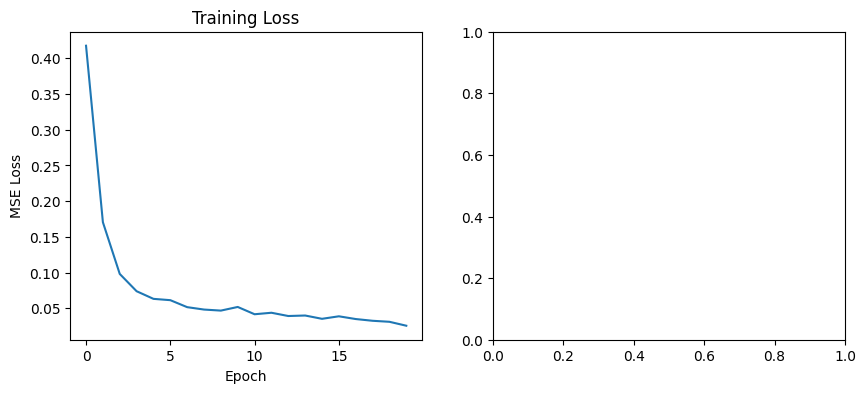

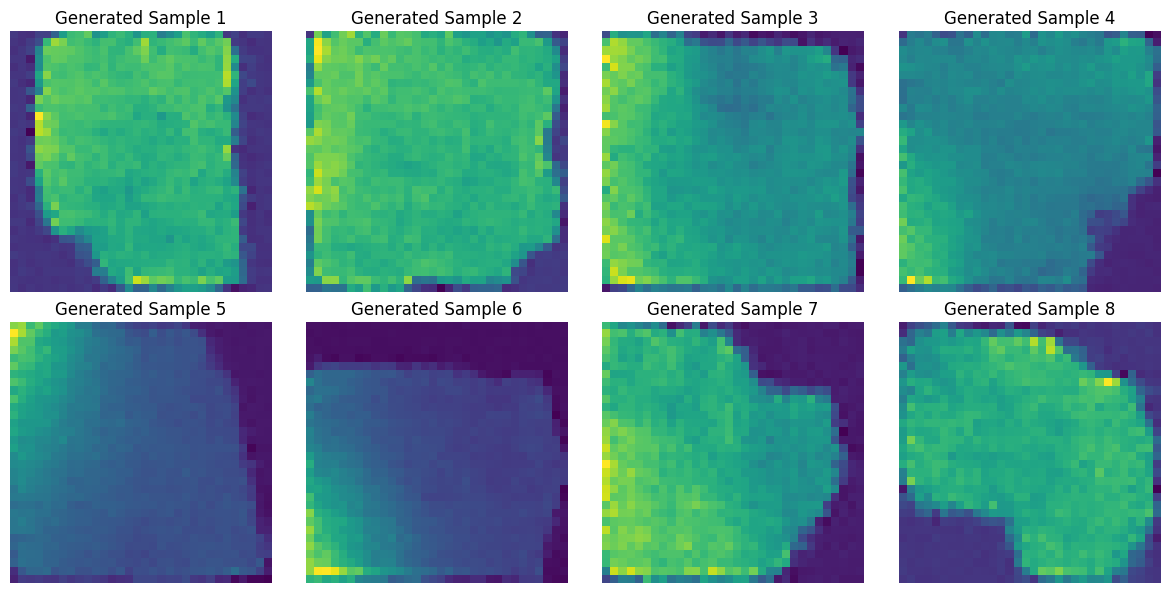

Training data examples:


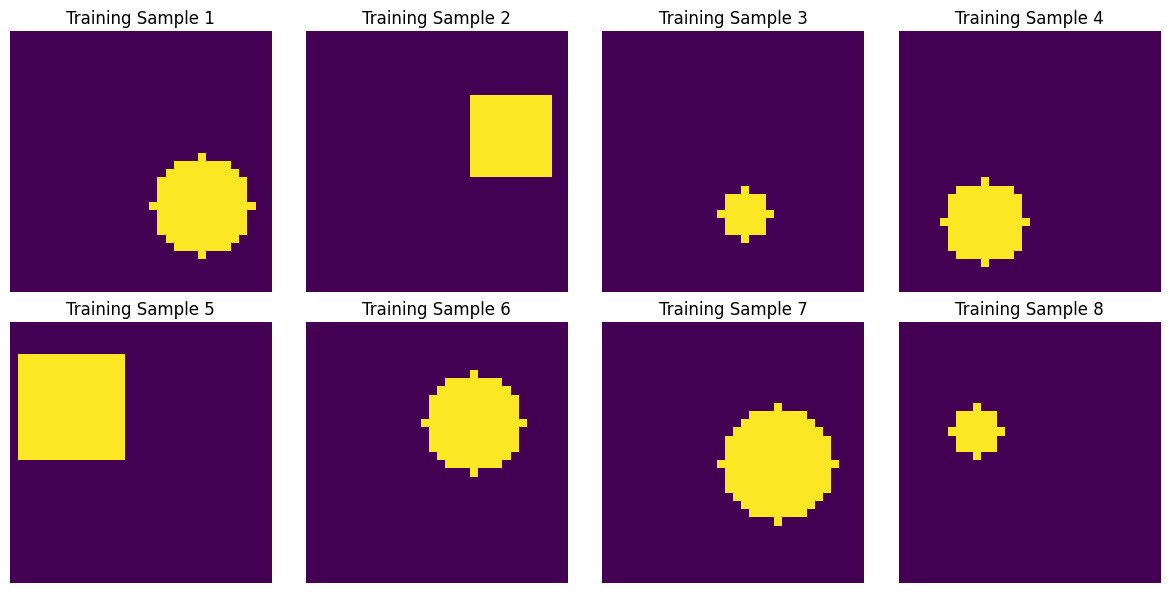

✅ Simple diffusion model complete!
The model learned to generate simple geometric shapes (circles and squares)
You can see the generated samples above - they should look similar to the training data!


In [ ]:

# This creates a minimal diffusion model that generates simple 2D patterns

# Install required packages
!pip install torch torchvision matplotlib numpy tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import math

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Simple U-Net architecture for denoising
class SimpleUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()

        # Encoder
        self.enc1 = nn.Conv2d(in_channels + 1, 64, 3, padding=1)  # +1 for time embedding
        self.enc2 = nn.Conv2d(64, 128, 3, padding=1, stride=2)
        self.enc3 = nn.Conv2d(128, 256, 3, padding=1, stride=2)

        # Bottleneck
        self.bottleneck = nn.Conv2d(256, 256, 3, padding=1)

        # Decoder
        self.dec3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = nn.ConvTranspose2d(256, 64, 2, stride=2)  # 256 because of skip connection
        self.dec1 = nn.Conv2d(128, out_channels, 3, padding=1)  # 128 because of skip connection

        self.relu = nn.ReLU()

    def forward(self, x, t):
        # Simple time embedding (just repeat the time value)
        t_embed = t.view(-1, 1, 1, 1).repeat(1, 1, x.shape[2], x.shape[3])
        x = torch.cat([x, t_embed], dim=1)

        # Encoder
        e1 = self.relu(self.enc1(x))
        e2 = self.relu(self.enc2(e1))
        e3 = self.relu(self.enc3(e2))

        # Bottleneck
        b = self.relu(self.bottleneck(e3))

        # Decoder with skip connections
        d3 = self.relu(self.dec3(b))
        d3 = torch.cat([d3, e2], dim=1)

        d2 = self.relu(self.dec2(d3))
        d2 = torch.cat([d2, e1], dim=1)

        output = self.dec1(d2)
        return output

# Diffusion process functions
def cosine_beta_schedule(timesteps, s=0.008):
    """Cosine noise schedule"""
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)

def forward_diffusion(x0, t, noise_schedule):
    """Add noise to images"""
    noise = torch.randn_like(x0)
    sqrt_alphas_cumprod = noise_schedule['sqrt_alphas_cumprod']
    sqrt_one_minus_alphas_cumprod = noise_schedule['sqrt_one_minus_alphas_cumprod']

    sqrt_alphas_cumprod_t = sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)

    return sqrt_alphas_cumprod_t * x0 + sqrt_one_minus_alphas_cumprod_t * noise, noise

# Create simple synthetic dataset (circles and squares)
def create_simple_shapes(n_samples=1000, img_size=32):
    """Create simple geometric shapes as training data"""
    images = []

    for _ in range(n_samples):
        img = torch.zeros(img_size, img_size)

        if torch.rand(1) < 0.5:  # Circle
            center_x, center_y = torch.randint(8, img_size-8, (2,))
            radius = torch.randint(3, 8, (1,)).item()
            y, x = torch.meshgrid(torch.arange(img_size), torch.arange(img_size), indexing='ij')
            mask = (x - center_x) ** 2 + (y - center_y) ** 2 <= radius ** 2
            img[mask] = 1.0
        else:  # Square
            size = torch.randint(6, 16, (1,)).item()
            x1 = torch.randint(0, img_size-size, (1,)).item()
            y1 = torch.randint(0, img_size-size, (1,)).item()
            img[y1:y1+size, x1:x1+size] = 1.0

        images.append(img)

    return torch.stack(images).unsqueeze(1)  # Add channel dimension

# Prepare noise schedule
timesteps = 300
betas = cosine_beta_schedule(timesteps)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

noise_schedule = {
    'betas': betas,
    'alphas': alphas,
    'alphas_cumprod': alphas_cumprod,
    'sqrt_alphas_cumprod': torch.sqrt(alphas_cumprod),
    'sqrt_one_minus_alphas_cumprod': torch.sqrt(1. - alphas_cumprod)
}

# Create dataset
print("Creating training data...")
train_data = create_simple_shapes(n_samples=500, img_size=32)
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_data),
    batch_size=16,
    shuffle=True
)

# Initialize model
model = SimpleUNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Move noise schedule to device
for key in noise_schedule:
    noise_schedule[key] = noise_schedule[key].to(device)

print("Starting training...")
model.train()
losses = []

# Training loop
for epoch in range(20):  # Reduced epochs for quick demo
    epoch_loss = 0
    for batch_idx, (batch,) in enumerate(train_loader):
        batch = batch.to(device)

        # Sample random timesteps
        t = torch.randint(0, timesteps, (batch.shape[0],)).to(device)

        # Forward diffusion (add noise)
        noisy_images, noise = forward_diffusion(batch, t, noise_schedule)

        # Predict noise
        predicted_noise = model(noisy_images, t.float() / timesteps)

        # Calculate loss
        loss = F.mse_loss(predicted_noise, noise)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/20, Loss: {avg_loss:.4f}")

# Plot training loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')

# Sampling function
@torch.no_grad()
def sample_images(model, noise_schedule, num_samples=4, img_size=32):
    model.eval()

    # Start with pure noise
    x = torch.randn(num_samples, 1, img_size, img_size).to(device)

    # Reverse diffusion process
    for t in reversed(range(timesteps)):
        t_batch = torch.full((num_samples,), t).to(device)

        # Predict noise
        predicted_noise = model(x, t_batch.float() / timesteps)

        # Remove predicted noise
        alpha = noise_schedule['alphas'][t]
        alpha_cumprod = noise_schedule['alphas_cumprod'][t]
        beta = noise_schedule['betas'][t]

        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)

        x = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / torch.sqrt(1 - alpha_cumprod)) * predicted_noise)
        if t > 0:
            x += torch.sqrt(beta) * noise

    return x

# Generate samples
print("Generating samples...")
samples = sample_images(model, noise_schedule, num_samples=8)

# Display results
plt.subplot(1, 2, 2)
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    if i < len(samples):
        img = samples[i].cpu().squeeze().numpy()
        ax.imshow(img, cmap='viridis')
        ax.set_title(f'Generated Sample {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Show some training data for comparison
print("Training data examples:")
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    if i < len(train_data):
        img = train_data[i].squeeze().numpy()
        ax.imshow(img, cmap='viridis')
        ax.set_title(f'Training Sample {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

print("✅ Simple diffusion model complete!")
print("The model learned to generate simple geometric shapes (circles and squares)")
print("You can see the generated samples above - they should look similar to the training data!")